## 1. Import Libraries

#### Import all the libraries to be used in this notebook. I prefer to do this at the beginning and added more libraries as I went along this project

In [1]:
import pyspark 
from pyspark.sql import SparkSession 
from textblob import TextBlob 
import re 
import string 
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px

In [4]:
#Create SparkSession 
spark = SparkSession.builder.appName('ProjectADE').getOrCreate()


In [3]:
#Create RDD from a text file

data = spark.sparkContext.textFile("bitcoin.csv")
data.take(2)

['Tue May 01 01:27:46 +0000 2018,leffler_iris,"<a href=""http://twitter.com"" rel=""nofollow"">Twitter Web Client</a>",,0,57,en,b\'RT @justinsuntron: Livestream with Taiwan legislator and #blockchain advocate Jason Hsu @augama will take place tonight at 9pm PST. Link co\'',
 ' ,,,,,,,']

In [5]:
data.count() #Checking the dataset

4076

## 2. Tweets Processing

##### **Text Preprocessing** is an important step for **Natural Language Processing** (NLP) tasks.

The preprocessing steps taken are:

1. Replacing Emoticons: Replace emoticons by using a  pre-defined dictionary containing emojis along with their meaning. (eg: ":))" to "very happy")

2. Replacing English abbreviations: Replace English abbreviation to correct spelling. (eg: "u" to "you")

3. Removing features: Remove RT,hyperlinks, @mentions and hashtag and numerical digits
  
4. Lower casing: Each text is converted to lowercase. 

In [6]:
# Definining dictionary containing all emojis with their meaning.
def resolve_emoticon(line):
   emoticon = {
    	':-)' : 'smile',
        ':)'  : 'sad',
    	':))' : 'very happy',
    	':)'  : 'happy',
    	':((' : 'very sad',
    	':('  : 'sad',
    	':-P' : 'tongue',
    	':-o' : 'gasp',
    	'>:-)':'angry'
   }   
   for key in emoticon:
      line = line.replace(key, emoticon[key])
   return line

In [7]:
# Defining dictionary containng English abbreviaton to correct spelling.

def abb_en(line):
   abbreviation_en = {
    'u': 'you',
    'thr': 'there',
    'asap': 'as soon as possible',
    'lv' : 'love',    
    'c' : 'see'
   } 
   abbrev = ' '.join (abbreviation_en.get(word, word) for word in line.split())
   return (resolve_emoticon(abbrev))  

In [8]:
# Defining set containing features in the tweets such RT, hyperlinks, @mentions and hash and numerical digit. 

def remove_features(data_str): 
    
   url_re= re.compile(r'https?://(\S+)') 
   num_re= re.compile(r'(\d+)') 
   mention_re= re.compile(r'(@|#)(\w+)') 
   RT_re= re.compile(r'RT(\s+)') 
    
   data_str= str(data_str) 
   data_str= RT_re.sub(' ', data_str) # remove RT 
   data_str= url_re.sub(' ', data_str) # remove hyperlinks \
   data_str= mention_re.sub(' ', data_str) # remove @mentions and hash 
   data_str= num_re.sub(' ', data_str) # remove numerical digit 
     
   return data_str

In [9]:
# Create function to obtain sentiment category
def categorize_polarity(x):
    if x > 0:
        return 'Positive'
    elif x < 0:
        return 'Negative'
    else:
        return 'Neutral'
 

# 3.Building Pipeline

#### Preparing a pipeline for sentiment analysis

In [10]:
sentiment_polarity = spark.sparkContext.textFile("bitcoin.csv") \
.map(lambda x:x.split(',')) \
.filter(lambda x:len(x) == 8) \
.filter(lambda x:len(x[0]) > 1) \
.map(lambda x:x[7])\
.map(lambda x:str(x).lower()) \
.map(lambda x:x.replace("'", "")) \
.map(lambda x:x.replace('"', '')) \
.map(lambda x:resolve_emoticon(x))\
.map(lambda x:remove_features(x))\
.map(lambda x:abb_en(x))\
.map(lambda x:TextBlob(x).sentiment.polarity)\
.map(lambda x:categorize_polarity(x))


sentiment_polarity.take(2)

['Neutral', 'Positive']

In [11]:
sentiment_polarity.count()

1180

In [12]:
text = spark.sparkContext.textFile('bitcoin.csv')\
.map(lambda x:x.split(','))\
.filter(lambda x:len(x)==8)\
.filter(lambda x:len(x[0])>1)\
.map(lambda x:x[7])\
.map(lambda x:str(x).lower())\
.map(lambda x:x.replace("'", ""))\
.map(lambda x:x.replace('"', ''))\
.map(lambda x:x.replace(r')', ''))\
.map(lambda x:x.replace(r'(', ''))\
.map(lambda x:x.replace(r'@', ''))\
.map(lambda x:x.replace(r'#', ''))

 

text.take(3)

['brt justinsuntron: livestream with taiwan legislator and blockchain advocate jason hsu augama will take place tonight at 9pm pst. link co',
 'brt murthaburke: get healthy with some coconut based oils! \\nhttps://t.co/aov8ndtxys \\nblockchain cryptocurrency crypto ethereum trapadr',
 'brt silentwhstlblwr: breaking: $link succesfully executes smartcontract live ropsten etherscan testnet. chainlink use cases are infinite']

In [13]:
created_at = spark.sparkContext.textFile('bitcoin.csv')\
.map(lambda x:x.split(','))\
.filter(lambda x:len(x)==8)\
.filter(lambda x:len(x[0])>1)\
.map(lambda x:x[0]) \
.map(lambda x:str(x).replace("'", ""))\
.map(lambda x:str(x).replace('"', ''))
 
created_at.take(2)

['Tue May 01 01:27:46 +0000 2018', 'Tue May 01 01:27:46 +0000 2018']

In [14]:
#I want 'created_at' to be index [0] and text to be index [1]

combine = created_at.zip(text)\
.map(lambda x:str(x).replace("'", ""))\
.map(lambda x:str(x).replace('"', ''))\
.map(lambda x:str(x).replace(r')', ''))\
.map(lambda x:str(x).replace(r'(', ''))\
.map(lambda x:str(x).replace('\\\\', ''))

                              
combine.take(3)

['Tue May 01 01:27:46 +0000 2018, brt justinsuntron: livestream with taiwan legislator and blockchain advocate jason hsu augama will take place tonight at 9pm pst. link co',
 'Tue May 01 01:27:46 +0000 2018, brt murthaburke: get healthy with some coconut based oils! nhttps://t.co/aov8ndtxys nblockchain cryptocurrency crypto ethereum trapadr',
 'Tue May 01 01:27:46 +0000 2018, brt silentwhstlblwr: breaking: $link succesfully executes smartcontract live ropsten etherscan testnet. chainlink use cases are infinite']

In [15]:
theData = spark.sparkContext.textFile('bitcoin.csv')\
.map(lambda x:x.split(','))\
.filter(lambda x:len(x)==8)\
.filter(lambda x:len(x[0])>1)\
.map(lambda x:x[1:7])\
.map(lambda x:str(x).lower())\
.map(lambda x:x.replace("'", ""))\
.map(lambda x:x.replace('"', ''))\
.map(lambda x:x.replace(r'[', ''))\
.map(lambda x:x.replace(r']', ''))


theData.take(10)

['leffler_iris, <a href=http://twitter.com rel=nofollow>twitter web client</a>, , 0, 57, en',
 'bmqxrxperymoht1, <a href=http://twitter.com rel=nofollow>twitter web client</a>, , 0, 60, en',
 'joshuahinson9, <a href=http://twitter.com/download/iphone rel=nofollow>twitter for iphone</a>, , 97, 449, en',
 'ndeso_bagoes, <a href=https://mobile.twitter.com rel=nofollow>twitter lite</a>, indonesia, 7304, 7426, en',
 'ugski79zyktcc3x, <a href=http://twitter.com rel=nofollow>twitter web client</a>, , 0, 30, en',
 'viktorkomarov5, <a href=https://nbvhmvmmh.com rel=nofollow>hgd hgeg egf </a>, amsterda, 10953, 11042, ru',
 'kamala4812ax, <a href=http://twitter.com rel=nofollow>twitter web client</a>, , 0, 0, en',
 'earnmoneynow24, <a href=https://www.botlibre.com rel=nofollow>bot libre!</a>, , 60, 376, en',
 'mentari_megga, <a href=http://twitter.com rel=nofollow>twitter web client</a>, di sini|w☺n☺s☺b☺, 1345, 2604, en',
 'vinod5473, <a href=http://twitter.com rel=nofollow>twitter web client</a>

In [16]:
#I want the sentiment_polarity to be at the end. So zip it with the rest of the data. 

bitcoinRDD = combine.zip(theData).zip(sentiment_polarity)\
.map(lambda x:str(x).replace("'", ""))\
.map(lambda x:str(x).replace('"', ''))\
.map(lambda x:str(x).replace(r')', ''))\
.map(lambda x:str(x).replace(r'(', ''))
 
bitcoinRDD.take(1)

['Tue May 01 01:27:46 +0000 2018, brt justinsuntron: livestream with taiwan legislator and blockchain advocate jason hsu augama will take place tonight at 9pm pst. link co, leffler_iris, <a href=http://twitter.com rel=nofollow>twitter web client</a>, , 0, 57, en, Neutral']

In [17]:
#Check the partitions

bitcoinRDD.getNumPartitions()

2

In [18]:
# I decided to change the partition to 1. The data isn't that big. 

bitcoinRDD2 = bitcoinRDD.repartition(1)

In [19]:
bitcoinRDD2.getNumPartitions()

1

In [20]:
#Save the output in text file in a folder ProjectADE

bitcoinRDD2.saveAsTextFile("ProjectADE")
print(bitcoinRDD2.count())

1180


# 4. Naming the header for the output

In [21]:
label=pd.read_csv("part-00000", index_col = None, header = 0)
label.head() #check data first 5 rows. 

,Tue May 01 01:27:46 +0000 2018,brt justinsuntron: livestream with taiwan legislator and blockchain advocate jason hsu augama will take place tonight at 9pm pst. link co,leffler_iris,<a href=http://twitter.com rel=nofollow>twitter web client</a>,,0,57,en,Neutral
0,Tue May 01 01:27:46 +0000 2018,brt murthaburke: get healthy with some coconu...,bmqxrxperymoht1,<a href=http://twitter.com rel=nofollow>twitt...,,0,60,en,Positive
1,Tue May 01 01:27:46 +0000 2018,brt silentwhstlblwr: breaking: $link succesfu...,joshuahinson9,<a href=http://twitter.com/download/iphone re...,,97,449,en,Positive
2,Tue May 01 01:27:46 +0000 2018,brt socialwalletinc: we are proud of our part...,ndeso_bagoes,<a href=https://mobile.twitter.com rel=nofoll...,indonesia,7304,7426,en,Positive
3,Tue May 01 01:27:48 +0000 2018,brt userexperienceu: iot ecosystems require o...,ugski79zyktcc3x,<a href=http://twitter.com rel=nofollow>twitt...,,0,30,en,Neutral
4,Tue May 01 01:27:49 +0000 2018,brt digitizecoin: digitize your loose change ...,viktorkomarov5,<a href=https://nbvhmvmmh.com rel=nofollow>hg...,amsterda,10953,11042,ru,Negative


In [22]:
#Create header for each column

label.columns = ["Created_At", "Text", "Screen_Name", "Source","Location", "Followers_Count", "Friends_Count", "Language", "Sentiment"] 

In [24]:
label.head()

,Created_At,Text,Screen_Name,Source,Location,Followers_Count,Friends_Count,Language,Sentiment
0,Tue May 01 01:27:46 +0000 2018,brt murthaburke: get healthy with some coconu...,bmqxrxperymoht1,<a href=http://twitter.com rel=nofollow>twitt...,,0,60,en,Positive
1,Tue May 01 01:27:46 +0000 2018,brt silentwhstlblwr: breaking: $link succesfu...,joshuahinson9,<a href=http://twitter.com/download/iphone re...,,97,449,en,Positive
2,Tue May 01 01:27:46 +0000 2018,brt socialwalletinc: we are proud of our part...,ndeso_bagoes,<a href=https://mobile.twitter.com rel=nofoll...,indonesia,7304,7426,en,Positive
3,Tue May 01 01:27:48 +0000 2018,brt userexperienceu: iot ecosystems require o...,ugski79zyktcc3x,<a href=http://twitter.com rel=nofollow>twitt...,,0,30,en,Neutral
4,Tue May 01 01:27:49 +0000 2018,brt digitizecoin: digitize your loose change ...,viktorkomarov5,<a href=https://nbvhmvmmh.com rel=nofollow>hg...,amsterda,10953,11042,ru,Negative


In [25]:
# Save the files to a csv file

label.to_csv("bitcoin_processed.csv", index = False)

## 5. Data Exploration


In [27]:
bitcoin_df=pd.read_csv("bitcoin_processed.csv")

In [28]:
bitcoin_df.count()

Created_At         1179
Text               1179
Screen_Name        1179
Source             1179
Location           1179
Followers_Count    1179
Friends_Count      1179
Language           1179
Sentiment          1179
dtype: int64

In [29]:
bitcoin_df['Sentiment'].value_counts()

 Neutral     596
 Positive    490
 Negative     93
Name: Sentiment, dtype: int64

In [30]:
bar_chart = bitcoin_df['Sentiment'].value_counts().rename_axis('Sentiment').to_frame('Total Tweets').reset_index()

In [31]:
bar_chart

,Sentiment,Total Tweets
0,Neutral,596
1,Positive,490
2,Negative,93


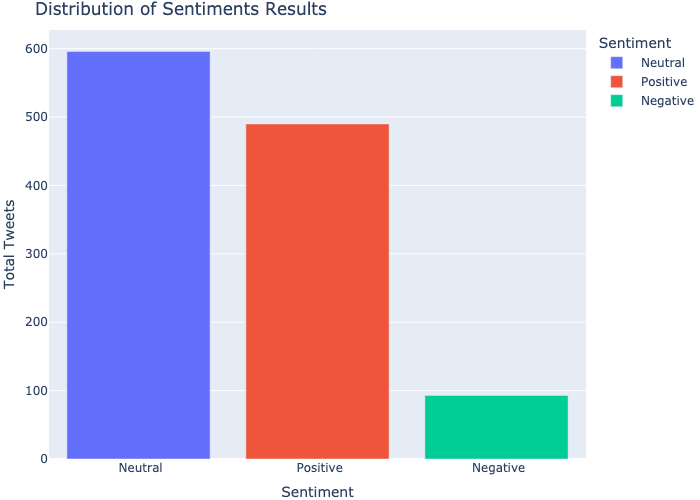

In [33]:

sentiments_barchart = px.bar(bar_chart, x = 'Sentiment', y = 'Total Tweets', color = 'Sentiment')
sentiments_barchart.update_layout(title = 'Distribution of Sentiments Results',
                                  margin={"r": 0, "t":30, "l":0, "b":0})
sentiments_barchart.show(renderer = 'png')




In [34]:
sentiments_barchart.write_image("Distribution of Sentiments Results.png")


#### Preview the result dataframe in preparation for export to Tableau

In [35]:
bitcoin_df.head()

,Created_At,Text,Screen_Name,Source,Location,Followers_Count,Friends_Count,Language,Sentiment
0,Tue May 01 01:27:46 +0000 2018,brt murthaburke: get healthy with some coconu...,bmqxrxperymoht1,<a href=http://twitter.com rel=nofollow>twitt...,,0,60,en,Positive
1,Tue May 01 01:27:46 +0000 2018,brt silentwhstlblwr: breaking: $link succesfu...,joshuahinson9,<a href=http://twitter.com/download/iphone re...,,97,449,en,Positive
2,Tue May 01 01:27:46 +0000 2018,brt socialwalletinc: we are proud of our part...,ndeso_bagoes,<a href=https://mobile.twitter.com rel=nofoll...,indonesia,7304,7426,en,Positive
3,Tue May 01 01:27:48 +0000 2018,brt userexperienceu: iot ecosystems require o...,ugski79zyktcc3x,<a href=http://twitter.com rel=nofollow>twitt...,,0,30,en,Neutral
4,Tue May 01 01:27:49 +0000 2018,brt digitizecoin: digitize your loose change ...,viktorkomarov5,<a href=https://nbvhmvmmh.com rel=nofollow>hg...,amsterda,10953,11042,ru,Negative


In [36]:
# Export to Excel file. 

bitcoin_df.to_excel('Tweets_Bitcoin_Tableau.xlsx', encoding = 'utf-8', index = False) 